In [58]:
pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB 640.0 kB/s eta 0:00:21
   ---------------------------------------- 0.1/13.3 MB 787.7 kB/s eta 0:00:17
   ---------------------------------------- 0.1/13.3 MB 1.1 MB/s eta 0:00:13
    --------------------------------------- 0.2/13.3 MB 1.3 MB/s eta 0:00:11
    --------------------------------------- 0.3/13.3 MB 1.3 MB/s eta 0:00:11
   - -------------------------------------- 0.4/13.3 MB 1.4 MB/s eta 0:00:10
   - -------------------------------------- 0.5/13.3 MB 1.5 MB/s eta 0:00:09
   - -------------------------------------- 0.6/13.3 MB 1.5 MB/s eta 0:00:09
   - -------------------------------------- 0.6/13.3 MB 1.6 MB/s eta 0:00:09
   -- ------------------------------------- 0.7/13.3 MB 1.6 MB/s eta 0:00:08
   -- ------------------------------------- 0.8/13.3 MB 1.6 MB/s eta 0:00:08
   -- ------------------------------------- 0.9/13.3 MB 1.7 MB/s eta 0:00:08
  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet

import math
from math import sqrt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv("amazon_orders_clean.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123987 entries, 0 to 123986
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   amazon_order_id               123987 non-null  object 
 1   purchase_date                 123987 non-null  object 
 2   last_updated_date             123987 non-null  object 
 3   order_status                  123987 non-null  object 
 4   fulfillment_channel           123987 non-null  object 
 5   sales_channel                 123987 non-null  object 
 6   ship_service_level            123987 non-null  object 
 7   product_name                  123801 non-null  object 
 8   sku                           123987 non-null  object 
 9   asin                          123987 non-null  object 
 10  item_status                   122714 non-null  object 
 11  quantity                      123987 non-null  int64  
 12  currency                      123928 non-nul

In [4]:
OrdersClean= pd.read_csv("orders_clean.csv")

In [5]:
OrdersClean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123987 entries, 0 to 123986
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   amazon_order_id               123987 non-null  object 
 1   purchase_date                 123987 non-null  object 
 2   last_updated_date             123987 non-null  object 
 3   order_status                  123987 non-null  object 
 4   fulfillment_channel           123987 non-null  object 
 5   sales_channel                 123987 non-null  object 
 6   ship_service_level            123987 non-null  object 
 7   product_name                  123982 non-null  object 
 8   sku                           123987 non-null  object 
 9   asin                          123987 non-null  object 
 10  item_status                   122714 non-null  object 
 11  quantity                      123987 non-null  int64  
 12  currency                      123928 non-nul

In [6]:
def column_info(df):
    """
    Generate summary information for each column in the DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame.

    Returns:
    DataFrame: DataFrame containing summary information for each column.
    """
    info = []
    for col in df.columns:
        data_type = df[col].dtype
        count = len(df[col])
        nan_count = df[col].isnull().sum()
        nan_percent = (nan_count / count) * 100 if count > 0 else 0
        unique_count = df[col].nunique()

        if pd.api.types.is_numeric_dtype(df[col]):
            max_value = df[col].max()
            min_value = df[col].min()
            sample_value = df[col].dropna().sample().iloc[0] if count - nan_count > 0 else None
        else:
            sample_value = df[col].dropna().sample().iloc[0] if count - nan_count > 0 else None
            max_value = 'no value'
            min_value = 'no value'

        info.append({
            'Column_name': col,
            'Data_Type': data_type,
            'Count': count,
            'NaN_Count': nan_count,
            'NaN_Percent': nan_percent,
            'Unique_Count': unique_count,
            'Max_Value': max_value,
            'Min_Value': min_value,
            'Sample_Value': sample_value
        })

    return pd.DataFrame(info)

In [7]:
column_info(OrdersClean)

,Column_name,Data_Type,Count,NaN_Count,NaN_Percent,Unique_Count,Max_Value,Min_Value,Sample_Value
0,amazon_order_id,object,123987,0,0.000000,119324,no value,no value,303-2762897-7369968
1,purchase_date,object,123987,0,0.000000,118679,no value,no value,2023-10-03 20:53:03+00:00
2,last_updated_date,object,123987,0,0.000000,115163,no value,no value,2024-04-22 22:20:54+00:00
3,order_status,object,123987,0,0.000000,4,no value,no value,Shipped
4,fulfillment_channel,object,123987,0,0.000000,2,no value,no value,Amazon
5,sales_channel,object,123987,0,0.000000,10,no value,no value,Amazon.it
6,ship_service_level,object,123987,0,0.000000,4,no value,no value,Expedited
7,product_name,object,123987,5,0.004033,577,no value,no value,Babydream Sicherheits-Wattestäbchen mit Sicherheitszone 4 x 72 Stück 100% Baumwolle
8,sku,object,123987,0,0.000000,755,no value,no value,Pmax-FBA-CR 1220-P5
9,asin,object,123987,0,0.000000,584,no value,no value,B00EEZ2U6E


GBPCount = (OrdersClean['currency'] == 'GBP').sum()
print(GBPCount)

Mevsimsel ve Trend Faktörleri:
Özellikler: month, day_of_week, holiday, season
Promosyonlar ve Kampanyalar:
Örnek: promotion_flag, campaign_effect
Geliri etkileyebilecek dışsal faktörler.
Örnek: interest_rate, unemployment_rate, GDP
Ürün veya Hizmetle İlgili Veriler:
Örnek: product_sales, service_usage
Fiyatlandırma:
Örnek: product_price, discount_rate
Müşteri Davranışı:
Örnek: customer_visits, conversion_rate
Web Trafik ve Sosyal Medya:
Örnek: web_traffic, social_media_mentions
Hava Durumu:
Örnek: temperature, precipitation

In [8]:
OrdersClean['Gelir']= OrdersClean['item_price']*OrdersClean['quantity']

In [9]:
OrdersSon = OrdersClean[['purchase_date','Gelir']]

In [10]:
OrdersSon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123987 entries, 0 to 123986
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   purchase_date  123987 non-null  object 
 1   Gelir          120299 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [11]:
OrdersSon['Gelir'].fillna(0, inplace = True)

In [12]:
OrdersSon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123987 entries, 0 to 123986
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   purchase_date  123987 non-null  object 
 1   Gelir          123987 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [13]:
OrdersSon.sample()

,purchase_date,Gelir
20143,2024-03-21 04:38:05+00:00,0.0


In [14]:
df = OrdersSon.copy()
df.sample()

,purchase_date,Gelir
34821,2024-01-12 19:47:43+00:00,3.49


In [15]:
df['purchase_date'] = pd.to_datetime(df['purchase_date']).dt.to_period("M").astype("datetime64[ns]")
data_monthlySon = df.groupby(df.purchase_date.dt.to_period("M"))[["Gelir"]].sum()
data_monthlySon.index = data_monthlySon.index.astype("datetime64[ns]")
data_monthlySon

,Gelir
purchase_date,
2022-06-01,41118.71
2022-07-01,90866.25
2022-08-01,61658.29
2022-09-01,76645.15
2022-10-01,85559.30
2022-11-01,250635.69
2022-12-01,102477.56
2023-01-01,90409.64
2023-02-01,78981.80


In [16]:
#duplicates = df[df.duplicated(subset=['purchase_date'], keep=False)]
#print(duplicates)

In [17]:
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

In [18]:
duplicates = df[df.duplicated(subset=['purchase_date'], keep=False)]
print(duplicates)

       purchase_date  Gelir
0         2024-05-01  21.92
1         2024-05-01  18.39
2         2024-05-01  12.05
3         2024-05-01   8.89
4         2024-05-01   9.49
...              ...    ...
123982    2022-06-01   0.00
123983    2022-06-01   0.00
123984    2022-06-01   0.00
123985    2022-06-01   0.00
123986    2022-06-01   0.00

[123987 rows x 2 columns]


In [19]:
df.dtypes

purchase_date    datetime64[ns]
Gelir                   float64
dtype: object

In [20]:
print(df)

       purchase_date  Gelir
0         2024-05-01  21.92
1         2024-05-01  18.39
2         2024-05-01  12.05
3         2024-05-01   8.89
4         2024-05-01   9.49
...              ...    ...
123982    2022-06-01   0.00
123983    2022-06-01   0.00
123984    2022-06-01   0.00
123985    2022-06-01   0.00
123986    2022-06-01   0.00

[123987 rows x 2 columns]


In [21]:
print(df.isna().sum())

# Sadece 'purchase_date' sütununu kontrol etmek için
print(df['purchase_date'].isna().sum())

purchase_date    0
Gelir            0
dtype: int64
0


In [22]:
data_monthly = df.set_index("purchase_date").asfreq('M')
print(data_monthly.isna().sum())

ValueError: cannot reindex on an axis with duplicate labels

In [25]:
data_monthly = df.set_index("purchase_date").resample('M').sum()
print(data_monthly.isna().sum())

Gelir    0
dtype: int64


In [26]:
print(data_monthly)

                   Gelir
purchase_date           
2022-06-30      41118.71
2022-07-31      90866.25
2022-08-31      61658.29
2022-09-30      76645.15
2022-10-31      85559.30
2022-11-30     250635.69
2022-12-31     102477.56
2023-01-31      90409.64
2023-02-28      78981.80
2023-03-31     179584.15
2023-04-30     104996.86
2023-05-31     105758.23
2023-06-30      97991.14
2023-07-31      98932.29
2023-08-31     103232.55
2023-09-30     113476.01
2023-10-31     117210.43
2023-11-30     261367.31
2023-12-31     157976.31
2024-01-31     145610.39
2024-02-29     112842.01
2024-03-31     135617.85
2024-04-30     101256.25
2024-05-31      90271.71


In [27]:
#data_monthly = data_monthly.fillna(0)

In [28]:
print(data_monthly.shape)

(24, 1)


In [29]:
data_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2022-06-30 to 2024-05-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gelir   24 non-null     float64
dtypes: float64(1)
memory usage: 384.0 bytes


In [30]:
data_monthly.head

<bound method NDFrame.head of                    Gelir
purchase_date           
2022-06-30      41118.71
2022-07-31      90866.25
2022-08-31      61658.29
2022-09-30      76645.15
2022-10-31      85559.30
2022-11-30     250635.69
2022-12-31     102477.56
2023-01-31      90409.64
2023-02-28      78981.80
2023-03-31     179584.15
2023-04-30     104996.86
2023-05-31     105758.23
2023-06-30      97991.14
2023-07-31      98932.29
2023-08-31     103232.55
2023-09-30     113476.01
2023-10-31     117210.43
2023-11-30     261367.31
2023-12-31     157976.31
2024-01-31     145610.39
2024-02-29     112842.01
2024-03-31     135617.85
2024-04-30     101256.25
2024-05-31      90271.71>

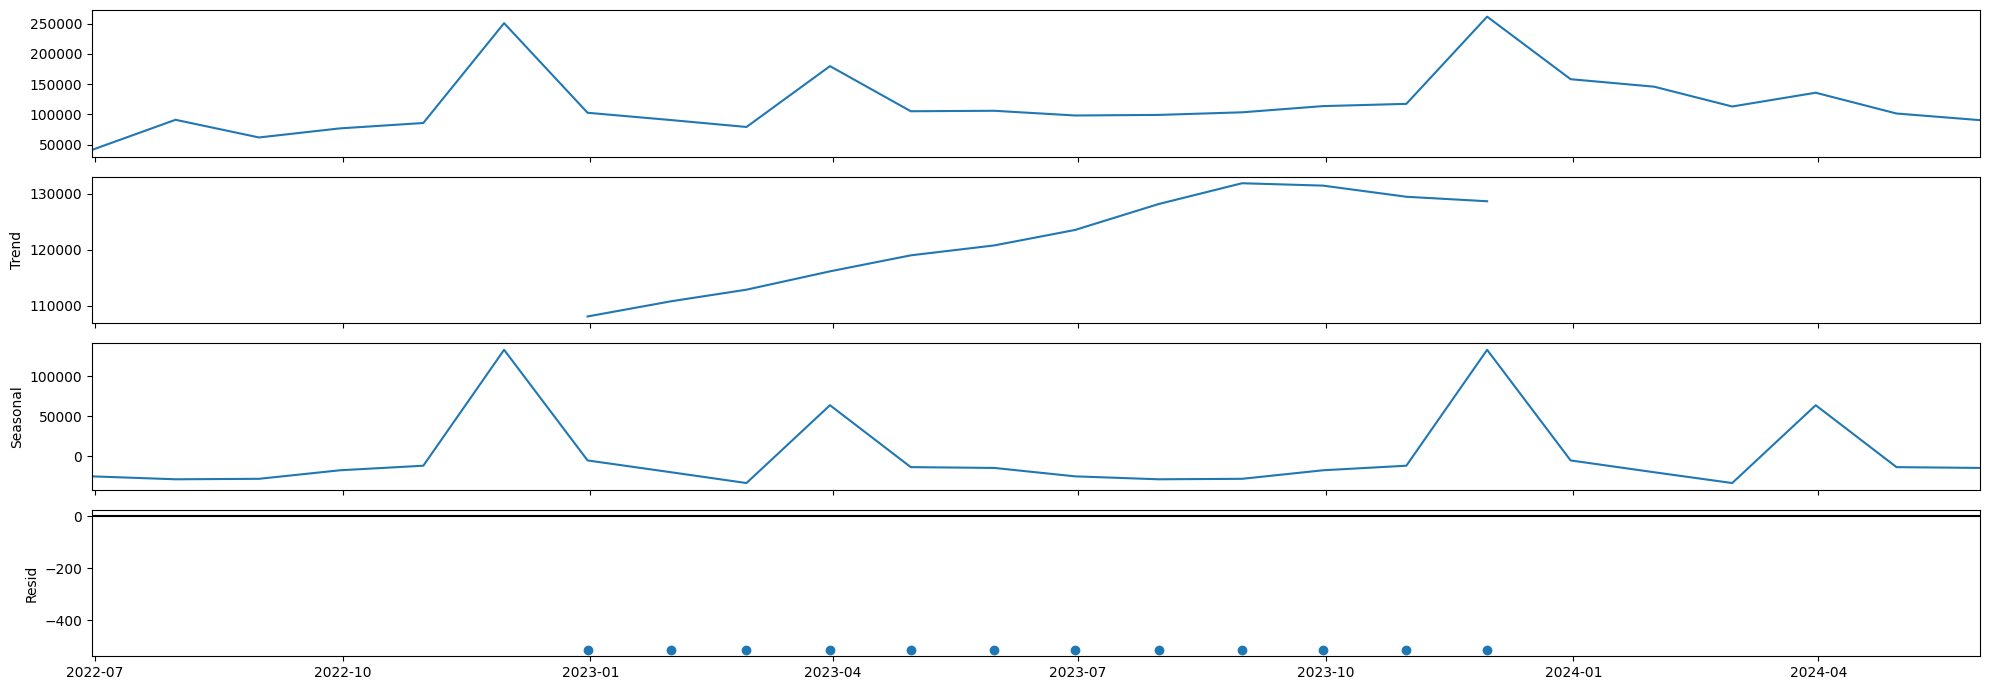

In [31]:
#data_monthly = df.set_index("purchase_date").asfreq('M')

plt.rcParams['figure.figsize'] = [20,7]
decomposition = sm.tsa.seasonal_decompose(data_monthly)
fig = decomposition.plot()
plt.show()

In [30]:
OrdersSon.dtypes

purchase_date     object
Gelir            float64
dtype: object

In [41]:
OrdersSon.head()

,purchase_date,Gelir
0,2024-05-30 19:42:29+00:00,21.92
1,2024-05-30 06:29:12+00:00,18.39
2,2024-05-30 02:04:18+00:00,12.05
3,2024-05-29 18:55:32+00:00,8.89
4,2024-05-29 08:22:11+00:00,9.49


In [34]:
OrdersSonNoDup = OrdersSon.groupby('purchase_date').sum()

In [35]:
OrdersSonNoDup.sample()

,Gelir
purchase_date,
2023-12-15 20:41:01+00:00,4.79


In [40]:
print(OrdersSonNoDup)

                           Gelir
purchase_date                   
2022-06-11 22:25:50+00:00  39.92
2022-06-11 23:38:42+00:00  83.25
2022-06-12 01:40:35+00:00  39.12
2022-06-12 05:34:26+00:00   9.89
2022-06-12 07:17:44+00:00  37.96
...                          ...
2024-05-30 21:19:25+00:00  12.20
2024-05-30 21:33:59+00:00   2.79
2024-05-30 21:38:42+00:00  11.79
2024-05-30 21:40:08+00:00   0.00
2024-05-30 21:44:29+00:00   4.02

[118679 rows x 1 columns]


In [50]:
duplicate = OrdersSonNoDup[OrdersSonNoDup.index.duplicated()]
 
print("Duplicate Rows :")
duplicate

Duplicate Rows :


,Gelir
purchase_date,


In [51]:
duplicate = OrdersSonNoDup[OrdersSonNoDup.duplicated()]
 
print("Duplicate Rows :")
duplicate

Duplicate Rows :


,Gelir
purchase_date,


<Axes: xlabel='purchase_date', ylabel='Gelir'>

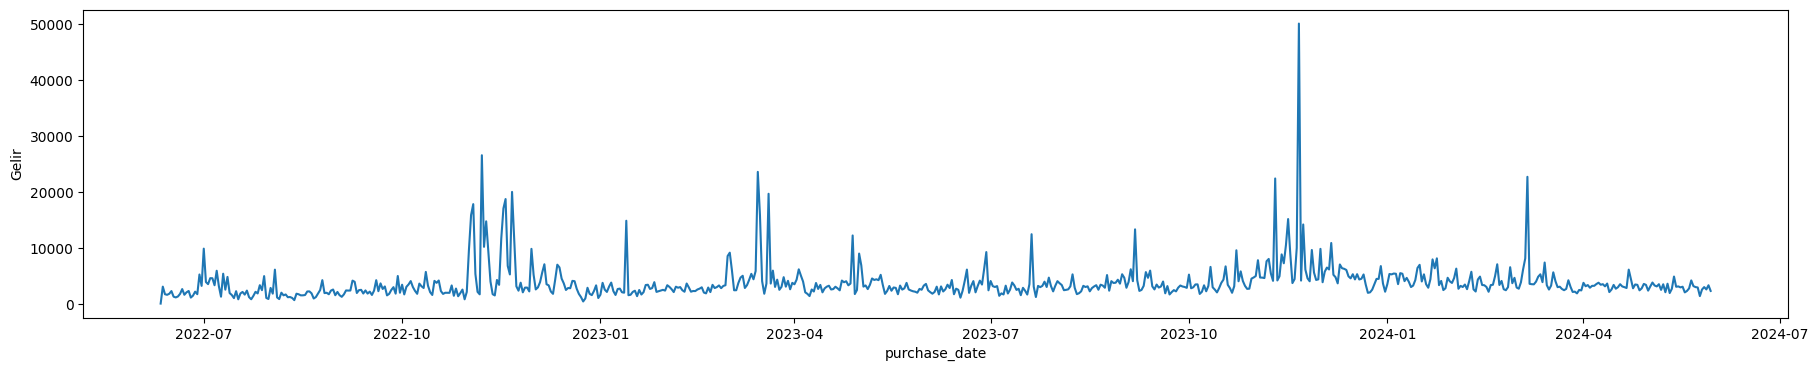

In [60]:
plt.figure(figsize=(22,4))
sns.lineplot(x = OrdersSonNoDup.index, y = OrdersSonNoDup.Gelir)

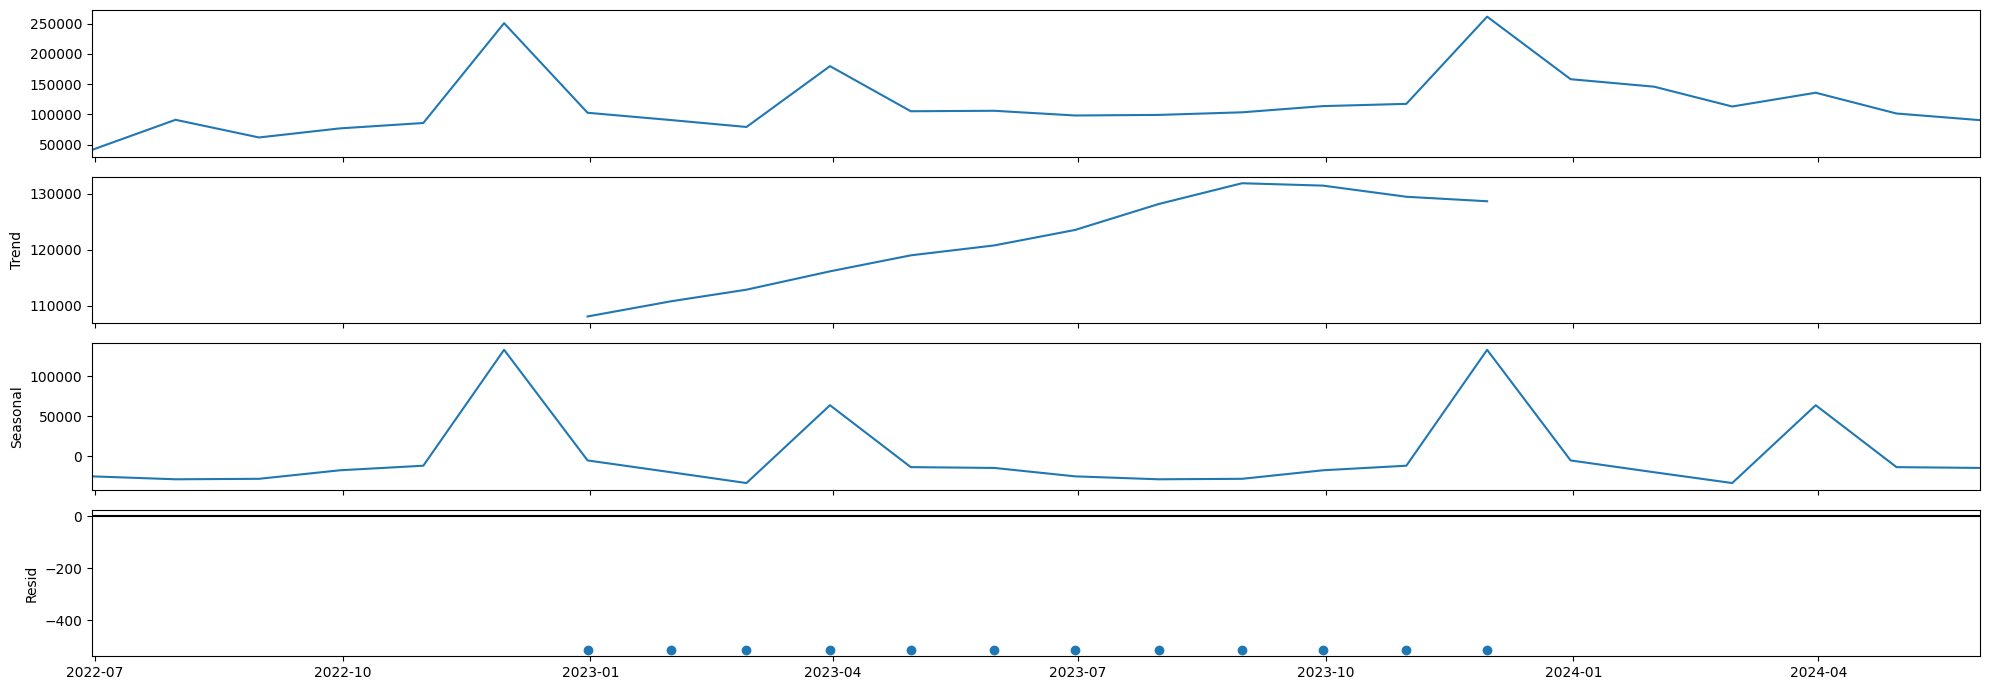

In [32]:
#data_monthly = df.set_index("purchase_date").asfreq('M')

plt.rcParams['figure.figsize'] = [20,7]
decomposition = sm.tsa.seasonal_decompose(data_monthly)
fig = decomposition.plot()
plt.show()

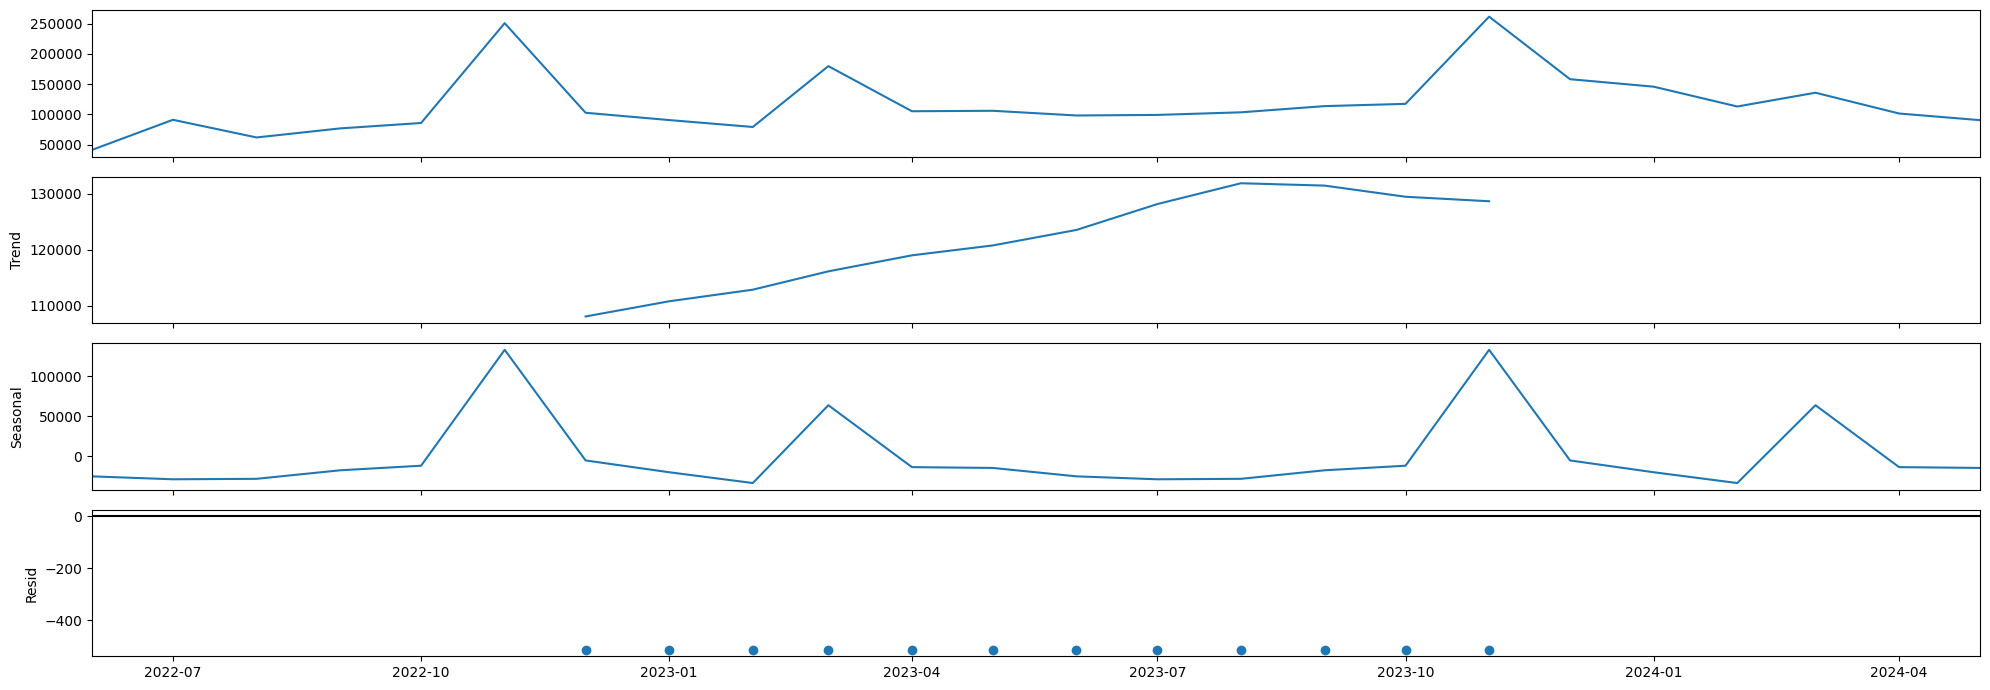

In [42]:
#data_monthly = df.set_index("purchase_date").asfreq('M')

plt.rcParams['figure.figsize'] = [20,7]
decomposition = sm.tsa.seasonal_decompose(data_monthlySon)
fig = decomposition.plot()
plt.show()

ACF ve PACF Grafikler
VEriler durağan değilse bu garafiklerin kontrolü ile serinin durağanlığı hakkında çıkarımlar yapabiliriz
Zaman serileri analizinde verilerin otokorelasyon ve kısmı otokorelasyon grafiğinin incelenmesi önemli bir adımdır. \\ 
Model terimlerinin sayısını belirlemek için Otokorelasyon fonksiyonu (ACF) ve kısmi otokorelasyon fonksiyonu (PACF) \\
grafiklerinden yararlanacağız

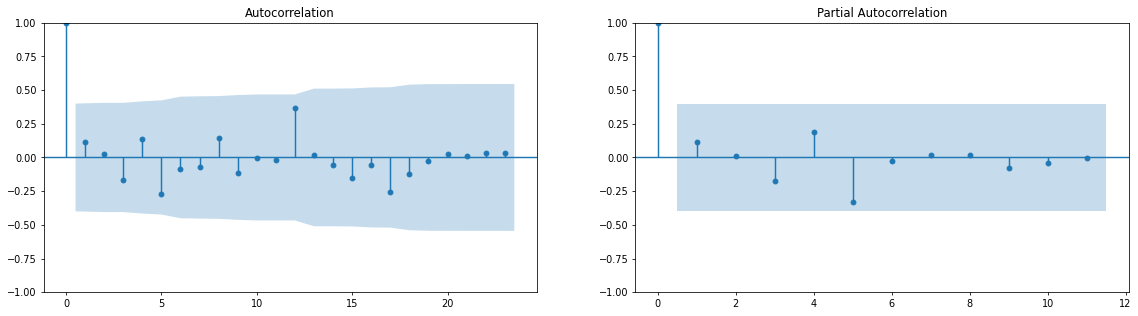

In [33]:
# otokorelasyon ve kısmı otokorelasyon grafikleri (ACF-PACF): 

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5), dpi= 70)

plot_acf(data_monthlySon.Gelir.tolist(), ax=ax1, lags=23)
plot_pacf(data_monthlySon.Gelir.tolist(), ax=ax2, lags=11, method="ywm")

plt.show()

In [ ]:
# Verilerin çizgi grafiği, zaman serileri bileşenleri ve ACF-PACF grafiğinden yola çıkarak \\ 
# \\ serinin durağan olmadığını söyleyebiliriz.

Görsel olarak yapılan Durağanlık durumu için (Trend ve Mevsimsellikden dolayı) bu tespitlerini dogrulamak üzere Dickey-Fuller ve KPSS hipotez testleri kullanılır

1- Augmented Dickey-Fuller Test

Sıfır Hipotez H0 : Seri Durağan Değildir
Alternati Hipotez H1 : Seri Durağandır (Birim Kök Yoktur)
2- Kwiatkowski-Phillips-Schmidt-Shin Test

Sıfır Hipotez H0 : Seri Durağandır (Birim Kök Yoktur)
Alternati Hipotez H1: Seri durağan değildir

In [34]:
# ADF Testi:

def adf(OrdersSon):
    adf_test = sm.tsa.adfuller(OrdersSon, autolag='AIC')
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    print("Seri Durağan Değildir") if adf_test[1] > 0.05 else print("Seri Durağandır(Birim Kök Yoktur)")

# KPSS Testi:

def kpss(OrdersSon):
    kpss_test = sm.tsa.kpss(OrdersSon)
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print("Seri Durağandır") if kpss_test[1] > 0.05 else print("Seri durağan değildir(Seri Birim Kök İçerir)")

adf(OrdersSonNoDup)
print()
kpss(OrdersSonNoDup)

NameError: name 'OrdersSonNoDup' is not defined

In [35]:
# ADF Testi:

def adf(OrdersSon):
    adf_test = sm.tsa.adfuller(OrdersSon, autolag='AIC')
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    print("Seri Durağan Değildir") if adf_test[1] > 0.05 else print("Seri Durağandır(Birim Kök Yoktur)")

# KPSS Testi:

def kpss(OrdersSon):
    kpss_test = sm.tsa.kpss(OrdersSon)
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print("Seri Durağandır") if kpss_test[1] > 0.05 else print("Seri durağan değildir(Seri Birim Kök İçerir)")

adf(data_monthlySon)
print()
kpss(data_monthlySon)

ADF Statistic: -4.27440626406421
p-value: 0.0004917956007241472
Seri Durağandır(Birim Kök Yoktur)

KPSS Statistic: 0.245535
p-value: 0.100000
Seri Durağandır


C:\Users\asena\AppData\Local\Temp\ipykernel_17636\4078608836.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = sm.tsa.kpss(OrdersSon)


In [57]:
# p-değerinin 0.05'ten (ve hatta 0.01'den) küçük olduğunu göz önünde bulundurarak, 
# bu zaman serisinin %95 (ve %99) güven seviyesinde durağan olduğunu söyleyebiliriz.
# ADF istatistiği negatif ise hipotez durağanlık lehine reddedilir.
# ADF testi bir birim kök bulamazsa, ancak KPSS testi bulursa, seri fark durağandır ve yine de fark alınması gerekir.
# Testlerden biri bile birim kökün varlığına işaret ediyorsa, seri durağandır diyemeyiz.

In [58]:
#Serimiz artık durağan hale gelmiş olsa bile hala ACF grafiğinde dalgalanmalar yani mevsimselliğin olduğunu ve gecikme sayılarının tekrarlarını incelediğimiz zaman \\
# \\ periyodun 7 olduğunu tespit edebiliyoruz. Ayrıca PACF’deki 7. gecikmenin de sınırlar dışında kaldığını görüyoruz.
# Periyot 7 olarak belirledikten sonra birinci dereceden mevsimsel fark alıyoruz:
# birinci dereceden farkı alınan seri üzerinde mevsimsel fark uygulanması: 

In [ ]:
# veri setinin eğitim ve test seti olarak ayrıştırılması : 2022-06-11 2024-05-30
# 1 Ocak 2017 - 31 Temmuz 2022 eğitim seti, 1 Ağustos 2022 - 31 Ağustos 2022 ise test seti olacak şekilde ayırıyoruz. 

#train_data = data_daily[:'2022-07-31']
#test_data = data_daily['2022-08-01':'2022-08-31']
#pred_df = test_data.copy()

In [36]:
#train_data = OrdersSonNoDup[OrdersSonNoDup['purchase_date'] <= '2023-12-31']
#test_data = OrdersSonNoDup[OrdersSonNoDup['purchase_date'] > '2023-12-31']
#pred_df = test_data.copy()

train_size = int(len(data_monthly) * 0.7)
train, test = data_monthly.iloc[:train_size], data_monthly.iloc[train_size:]
pred_df = test.copy()
pred_df1 = test.copy()
pred_df2 = test.copy()
pred_df3 = test.copy()
pred_df4 = test.copy()
pred_df6 = test.copy()
pred_df7 = test.copy()
pred_df8 = test.copy()

ARIMA modellemesi


<Axes: xlabel='purchase_date'>

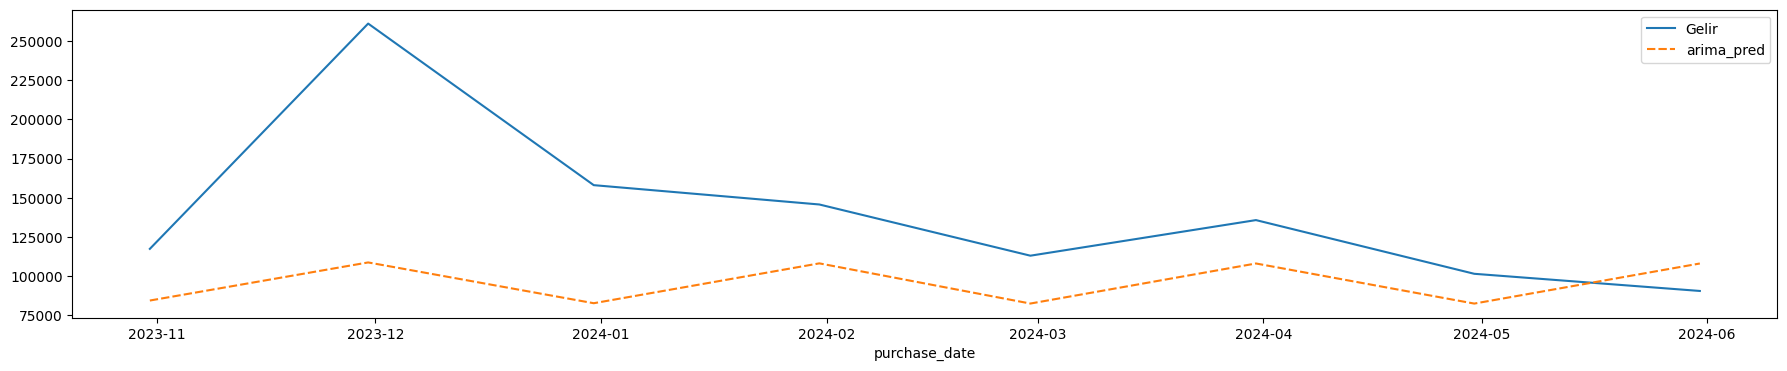

In [37]:
# ARIMA (2,1,2)
#Verileri eğitim ve test seti olarak ikiye ayırıyoruz

arima_model = sm.tsa.arima.ARIMA(np.asarray(train.Gelir),order=(2,1,2))
arima_model_fit = arima_model.fit()
arima_pred = arima_model_fit.forecast(len(test.Gelir),disp=False)

pred_df["arima_pred"] = arima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(pred_df[['Gelir', 'arima_pred']])

C:\Users\asena\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='purchase_date'>

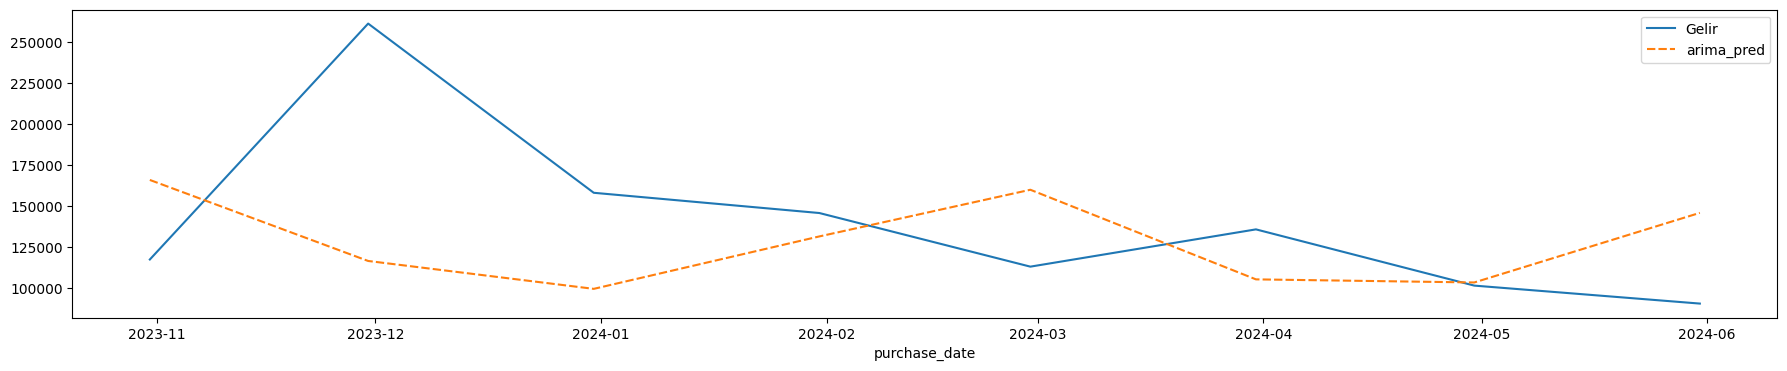

In [38]:
# ARIMA (2,1,2)
#Verileri eğitim ve test seti olarak ikiye ayırıyoruz

arima_model = sm.tsa.arima.ARIMA(np.asarray(train.Gelir),order=(3,1,2))
arima_model_fit = arima_model.fit()
arima_pred = arima_model_fit.forecast(len(test.Gelir),disp=False)

pred_df["arima_pred"] = arima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(pred_df[['Gelir', 'arima_pred']])

C:\Users\asena\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='purchase_date'>

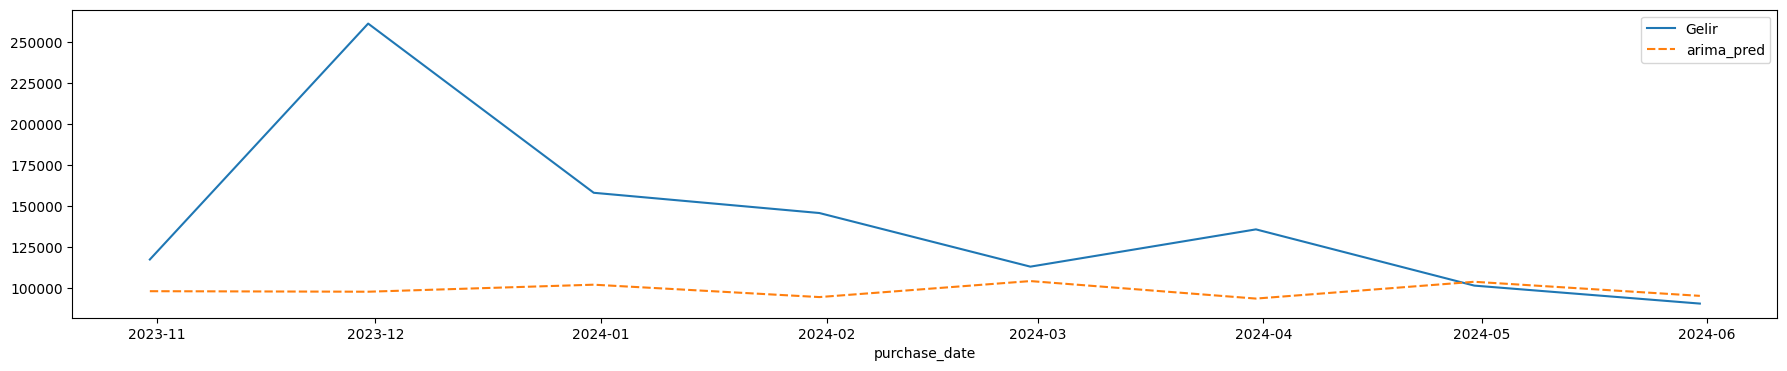

In [39]:
# ARIMA (2,1,2)
#Verileri eğitim ve test seti olarak ikiye ayırıyoruz

arima_model = sm.tsa.arima.ARIMA(np.asarray(train.Gelir),order=(2,1,3))
arima_model_fit = arima_model.fit()
arima_pred = arima_model_fit.forecast(len(test.Gelir),disp=False)

pred_df["arima_pred"] = arima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(pred_df[['Gelir', 'arima_pred']])

<Axes: xlabel='purchase_date'>

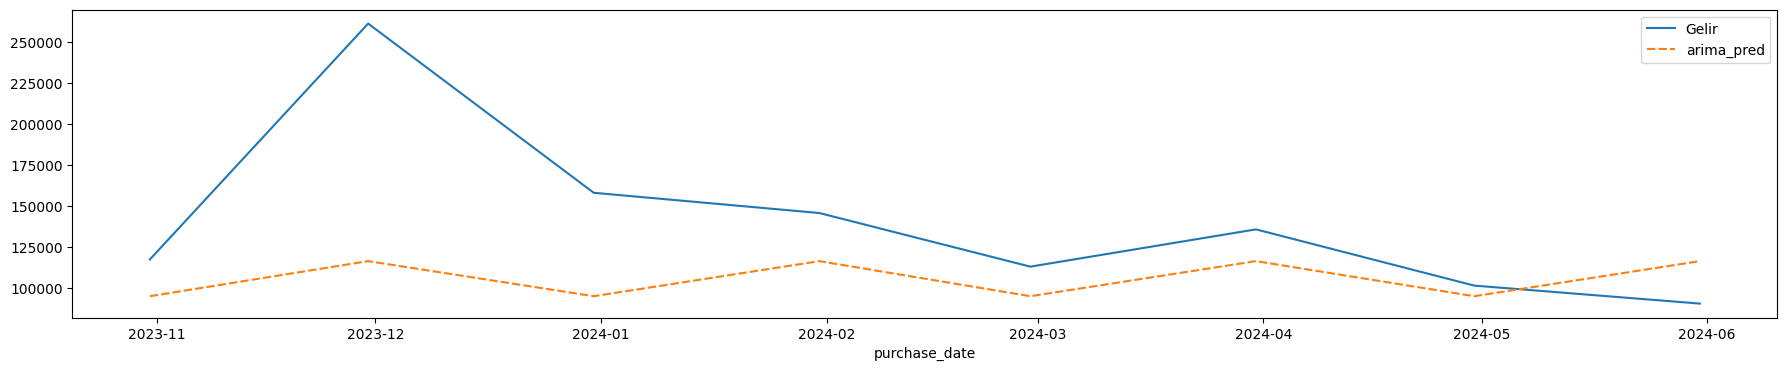

In [40]:
# ARIMA (2,1,2)
#Verileri eğitim ve test seti olarak ikiye ayırıyoruz

arima_model = sm.tsa.arima.ARIMA(np.asarray(train.Gelir),order=(1,1,2))
arima_model_fit = arima_model.fit()
arima_pred = arima_model_fit.forecast(len(test.Gelir),disp=False)

pred_df["arima_pred"] = arima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(pred_df[['Gelir', 'arima_pred']])

<Axes: xlabel='purchase_date'>

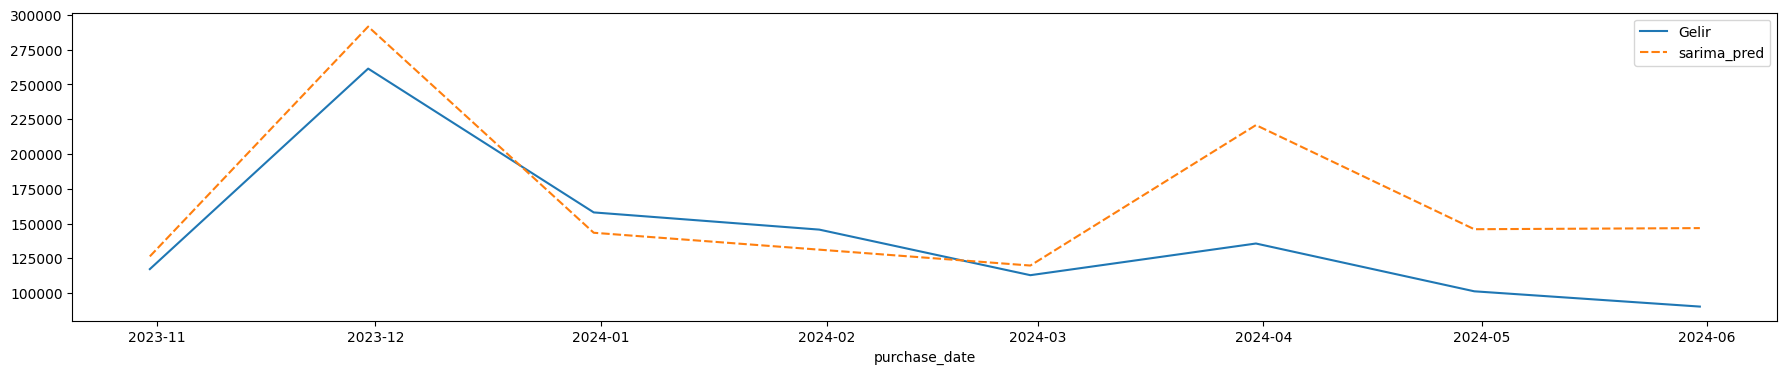

In [41]:
# SARIMA (2,1,2) (1,1,1,7)

sarima_model = SARIMAX(np.asarray(train), order=(2, 1, 2), seasonal_order=(1,1,1,12))
sarima_model_fit = sarima_model.fit()
sarima_pred = sarima_model_fit.forecast(len(test))

pred_df["sarima_pred"] = sarima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(pred_df[['Gelir', 'sarima_pred']])

<Axes: xlabel='purchase_date'>

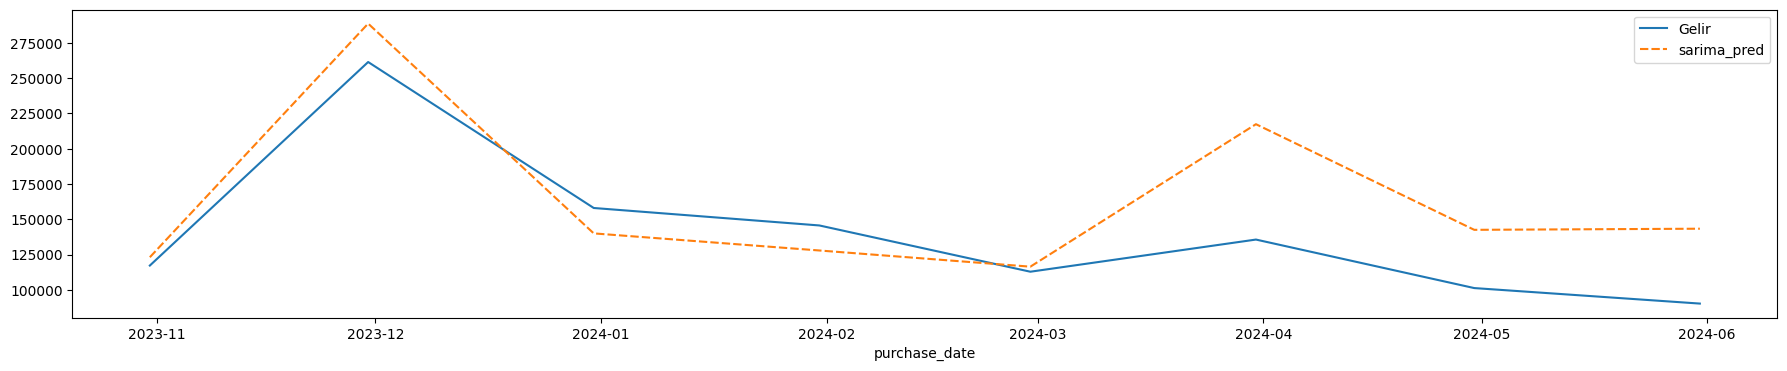

In [42]:
# SARIMA (2,1,2) (1,1,1,7)

sarima_model = SARIMAX(np.asarray(train), order=(1, 1, 2), seasonal_order=(1,1,1,12))
sarima_model_fit = sarima_model.fit()
sarima_pred = sarima_model_fit.forecast(len(test))

pred_df1["sarima_pred"] = sarima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(pred_df1[['Gelir', 'sarima_pred']])

# SARIMA aylik

<Axes: xlabel='purchase_date'>

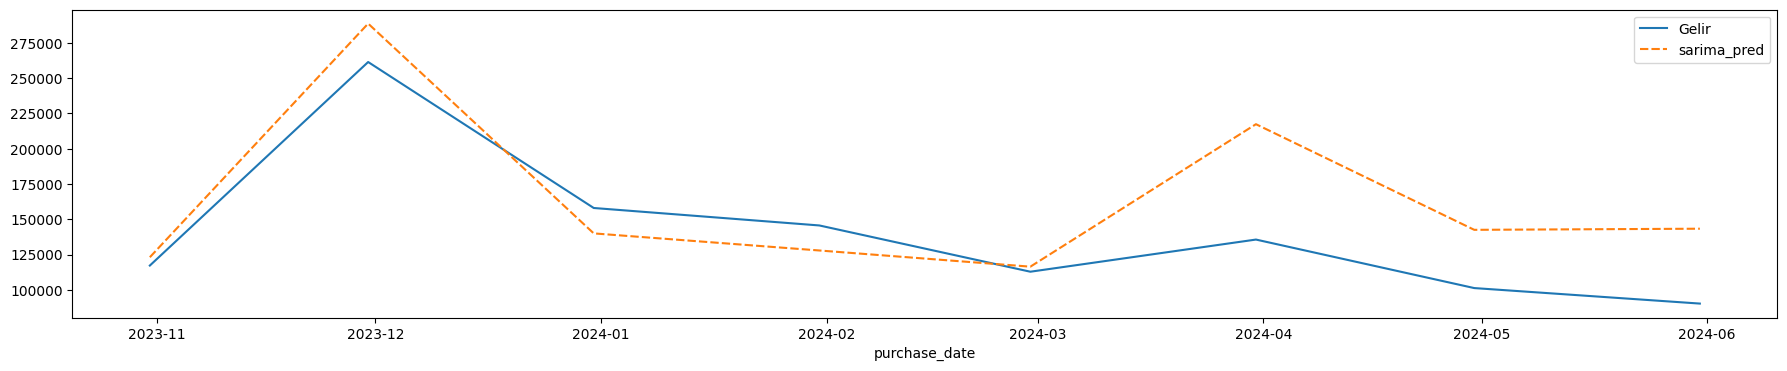

In [43]:
# SARIMA (2,1,2) (1,1,1,7)

sarima_model = SARIMAX(np.asarray(train), order=(1, 1, 2), seasonal_order=(1,1,1,12))
sarima_model_fit = sarima_model.fit()
sarima_pred = sarima_model_fit.forecast(len(test))

pred_df2["sarima_pred"] = sarima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(pred_df2[['Gelir', 'sarima_pred']])

<Axes: xlabel='purchase_date'>

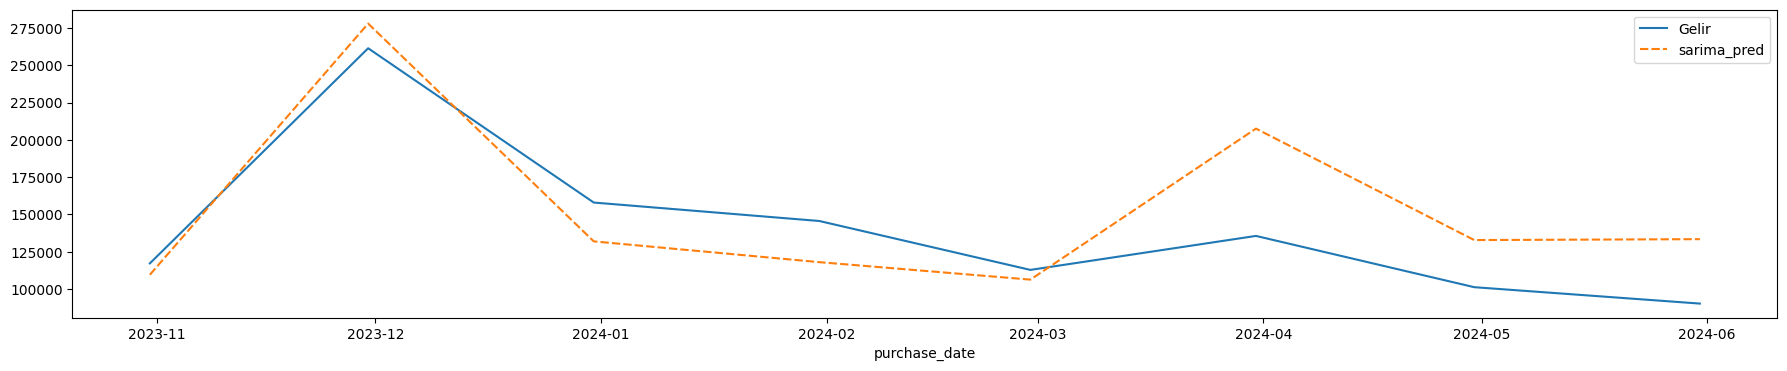

In [45]:
sarima_model = SARIMAX(np.asarray(train), order=(3, 1, 3), seasonal_order=(1,1,1,12))
sarima_model_fit = sarima_model.fit()
sarima_pred = sarima_model_fit.forecast(len(test))

pred_df["sarima_pred"] = sarima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(pred_df[['Gelir', 'sarima_pred']])

C:\Users\asena\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


TypeError: object of type 'Axes' has no len()

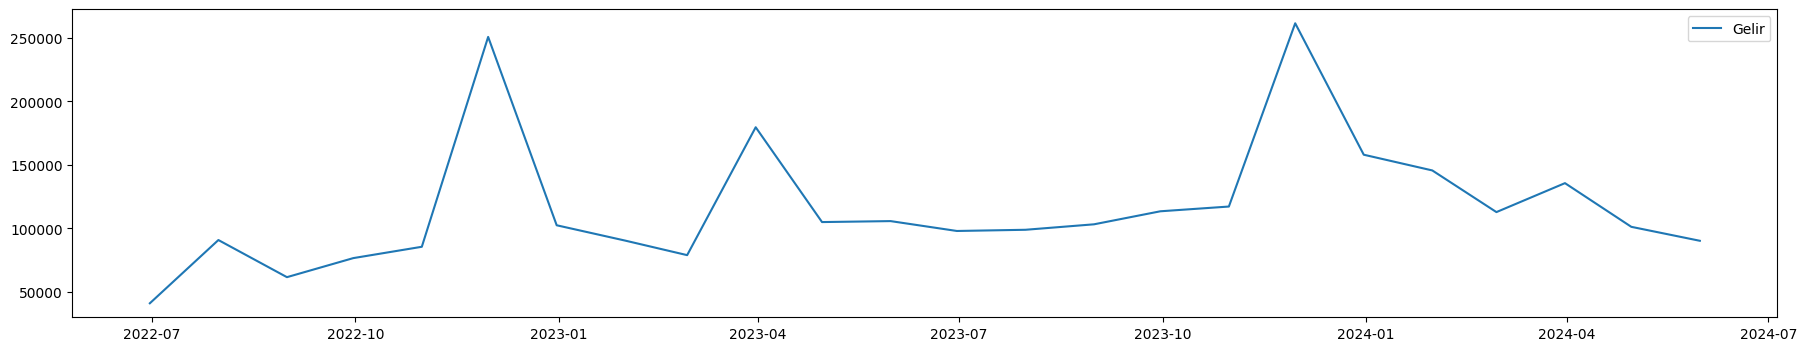

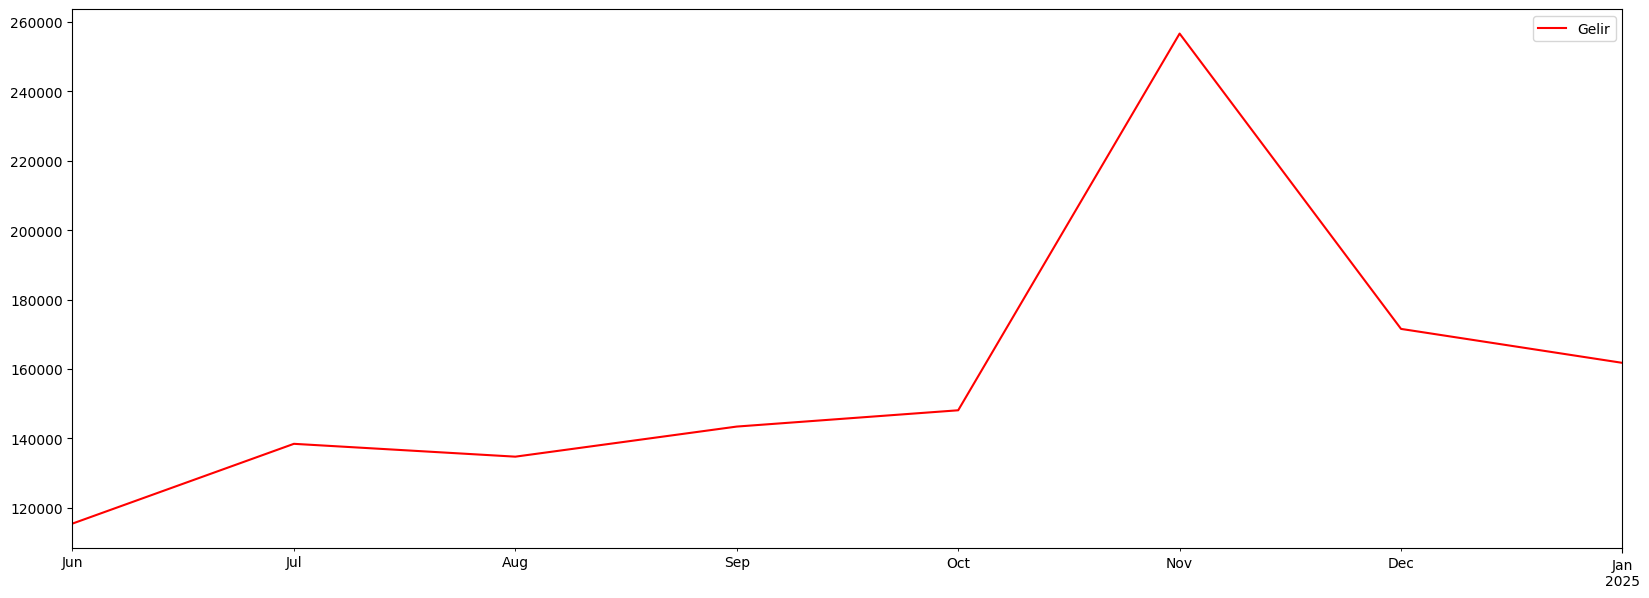

In [49]:
sarima_model = SARIMAX(np.asarray(data_monthlySon), order=(2, 1, 2), seasonal_order=(1,1,1,12))
sarima_model_fit = sarima_model.fit()
sarima_pred = sarima_model_fit.forecast(len(pd.date_range("2024-06-01", "2025-02-01", freq="M")))
dfForecast = pd.concat([data_monthly, pd.DataFrame(sarima_pred.round(2), pd.date_range("2024-06-01", "2025-02-01", freq="M"), ["Gelir"])])
plt.figure(figsize=(22,4))
sns.lineplot(dfForecast.loc[:"2024-06-01"][['Gelir']], color='red')
sns.lineplot(dfForecast.loc["2024-06-01":][['Gelir']].plot(color="red"))
plt.legend(["Orjinal", "Forcast"])

In [50]:
dfForecast

,Gelir
2022-06-30,41118.71
2022-07-31,90866.25
2022-08-31,61658.29
2022-09-30,76645.15
2022-10-31,85559.30
2022-11-30,250635.69
2022-12-31,102477.56
2023-01-31,90409.64
2023-02-28,78981.80
2023-03-31,179584.15



# SARIMA günlük

In [147]:
train_size_gunluk = int(len(OrdersSonNoDup) * 0.7)
trainGunluk, testGunluk = OrdersSonNoDup.iloc[:train_size_gunluk], OrdersSonNoDup.iloc[train_size_gunluk:]
pred_df_gunluk = testGunluk.copy()

In [ ]:
sarima_model = SARIMAX(np.asarray(trainGunluk), order=(1, 1, 2), seasonal_order=(1,1,1,360))
sarima_model_fit = sarima_model.fit()
sarima_pred = sarima_model_fit.forecast(len(testGunluk))

pred_df_gunluk["sarima_pred"] = sarima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(pred_df_gunluk[['Gelir', 'sarima_pred']])

In [ ]:
# PROPHET

prophet_df = data_daily.reset_index()
prophet_df.columns = ["ds","y"]

train_data_prophet = prophet_df[prophet_df['ds'] < '2022-08-01']
test_data_prophet = prophet_df[(prophet_df['ds'] >= '2022-08-01') & (prophet_df['ds'] <= '2022-08-31')]

prophet_model = Prophet()
prophet_model.fit(train_data_prophet)
model_predict = prophet_model.predict(test_data_prophet)

pred_df["prophet_yhat"] = model_predict["yhat"].values.round(2)
pred_df["prophet_yhat_lower"] = model_predict["yhat_lower"].values.round(2)
pred_df["prophet_yhat_upper"] = model_predict["yhat_upper"].values.round(2)

plt.figure(figsize=(22,4))
sns.lineplot(data = pred_df[['Gelir', 'prophet_yhat']])

In [73]:
arima_mape = mean_absolute_percentage_error(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_r = r2_score(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_rmse = math.sqrt(mean_squared_error(pred_df["Gelir"].values, pred_df["arima_pred"].values))

sarima_mape = mean_absolute_percentage_error(pred_df["Gelir"].values, pred_df["sarima_pred"].values)
sarima_r = r2_score(pred_df["Gelir"].values, pred_df["sarima_pred"].values)
sarima_rmse = math.sqrt(mean_squared_error(pred_df["Gelir"].values, pred_df["sarima_pred"].values))

results = {
        'ARIMA': [arima_mape,arima_rmse,arima_r],
        'SARIMA': [sarima_mape,sarima_rmse,sarima_r]}
results = pd.DataFrame(results,index=['MAE','RMSE','R2'])
results

,ARIMA,SARIMA
MAE,0.245719,0.267546
RMSE,66055.239629,41670.351672
R2,-0.716635,0.316847


In [75]:
arima_mape = mean_absolute_percentage_error(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_r = r2_score(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_rmse = math.sqrt(mean_squared_error(pred_df["Gelir"].values, pred_df["arima_pred"].values))

sarima_mape1 = mean_absolute_percentage_error(pred_df1["Gelir"].values, pred_df1["sarima_pred"].values)
sarima_r1 = r2_score(pred_df1["Gelir"].values, pred_df1["sarima_pred"].values)
sarima_rmse1 = math.sqrt(mean_squared_error(pred_df1["Gelir"].values, pred_df1["sarima_pred"].values))

results = {
        'ARIMA': [arima_mape,arima_rmse,arima_r],
        'SARIMA1': [sarima_mape1,sarima_rmse1,sarima_r1]}
results = pd.DataFrame(results,index=['MAE','RMSE','R2'])
results

,ARIMA,SARIMA1
MAE,0.250414,0.252388
RMSE,59001.278638,39714.050866
R2,-0.369576,0.379486


In [76]:
arima_mape = mean_absolute_percentage_error(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_r = r2_score(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_rmse = math.sqrt(mean_squared_error(pred_df["Gelir"].values, pred_df["arima_pred"].values))

sarima_mape2 = mean_absolute_percentage_error(pred_df2["Gelir"].values, pred_df2["sarima_pred"].values)
sarima_r2 = r2_score(pred_df2["Gelir"].values, pred_df2["sarima_pred"].values)
sarima_rmse2 = math.sqrt(mean_squared_error(pred_df2["Gelir"].values, pred_df2["sarima_pred"].values))

results = {
        'ARIMA': [arima_mape,arima_rmse,arima_r],
        'SARIMA2': [sarima_mape2,sarima_rmse2,sarima_r2]}
results = pd.DataFrame(results,index=['MAE','RMSE','R2'])
results

,ARIMA,SARIMA2
MAE,0.250414,0.252388
RMSE,59001.278638,39714.050866
R2,-0.369576,0.379486


In [79]:
arima_mape = mean_absolute_percentage_error(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_r = r2_score(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_rmse = math.sqrt(mean_squared_error(pred_df["Gelir"].values, pred_df["arima_pred"].values))

sarima_mape3 = mean_absolute_percentage_error(pred_df3["Gelir"].values, pred_df3["sarima_pred"].values)
sarima_r3 = r2_score(pred_df3["Gelir"].values, pred_df3["sarima_pred"].values)
sarima_rmse3 = math.sqrt(mean_squared_error(pred_df3["Gelir"].values, pred_df3["sarima_pred"].values))

results = {
        'ARIMA': [arima_mape,arima_rmse,arima_r],
        'SARIMA3': [sarima_mape3,sarima_rmse3,sarima_r3]}
results = pd.DataFrame(results,index=['MAE','RMSE','R2'])
results

,ARIMA,SARIMA3
MAE,0.250414,0.169891
RMSE,59001.278638,42273.737715
R2,-0.369576,0.296920


In [85]:
arima_mape = mean_absolute_percentage_error(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_r = r2_score(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_rmse = math.sqrt(mean_squared_error(pred_df["Gelir"].values, pred_df["arima_pred"].values))

sarima_mape4 = mean_absolute_percentage_error(pred_df4["Gelir"].values, pred_df4["sarima_pred"].values)
sarima_r4 = r2_score(pred_df4["Gelir"].values, pred_df4["sarima_pred"].values)
sarima_rmse4 = math.sqrt(mean_squared_error(pred_df4["Gelir"].values, pred_df4["sarima_pred"].values))

results = {
        'ARIMA': [arima_mape,arima_rmse,arima_r],
        'SARIMA4': [sarima_mape4,sarima_rmse4,sarima_r4]}
results = pd.DataFrame(results,index=['MAE','RMSE','R2'])
results

,ARIMA,SARIMA4
MAE,0.250414,0.254723
RMSE,59001.278638,40066.590818
R2,-0.369576,0.368420


In [94]:
arima_mape = mean_absolute_percentage_error(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_r = r2_score(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_rmse = math.sqrt(mean_squared_error(pred_df["Gelir"].values, pred_df["arima_pred"].values))

sarima_mape5 = mean_absolute_percentage_error(pred_df["Gelir"].values, pred_df["sarima_pred"].values)
sarima_r5 = r2_score(pred_df["Gelir"].values, pred_df["sarima_pred"].values)
sarima_rmse5 = math.sqrt(mean_squared_error(pred_df["Gelir"].values, pred_df["sarima_pred"].values))

results = {
        'ARIMA': [arima_mape,arima_rmse,arima_r],
        'SARIMA5': [sarima_mape5,sarima_rmse5,sarima_r5]}
results = pd.DataFrame(results,index=['MAE','RMSE','R2'])
results

,ARIMA,SARIMA5
MAE,0.250414,0.232546
RMSE,59001.278638,35075.617872
R2,-0.369576,0.515968


<Axes: xlabel='purchase_date'>

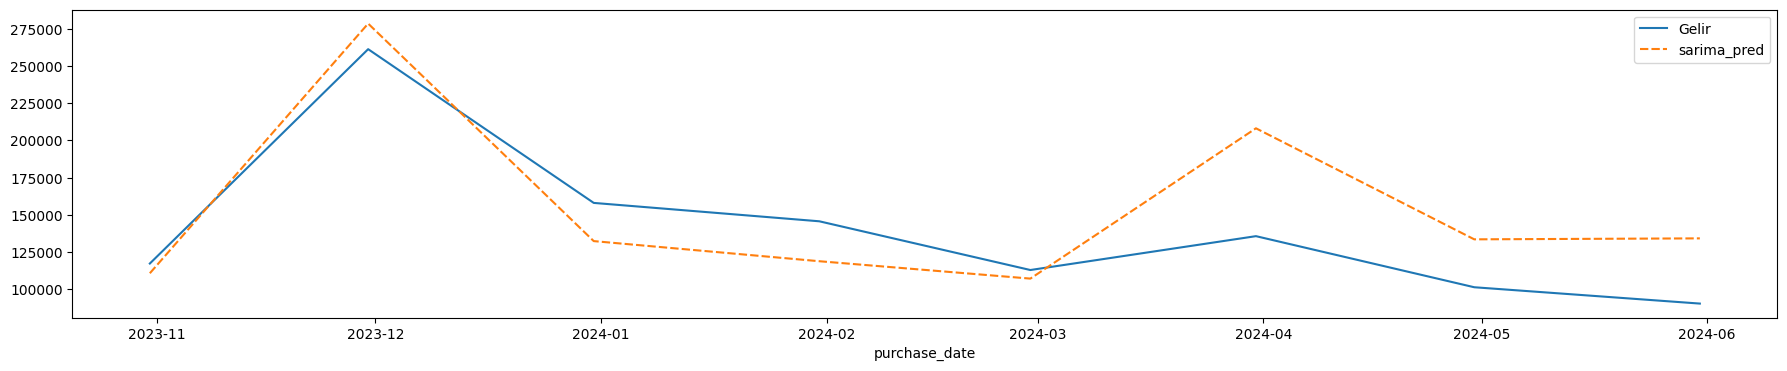

In [121]:
sarima_model = SARIMAX(np.asarray(train), order=(3, 1, 3), seasonal_order=(3,1,2,12))
sarima_model_fit = sarima_model.fit()
sarima_pred = sarima_model_fit.forecast(len(test))

pred_df8["sarima_pred"] = sarima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(pred_df8[['Gelir', 'sarima_pred']])

In [122]:
arima_mape = mean_absolute_percentage_error(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_r = r2_score(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_rmse = math.sqrt(mean_squared_error(pred_df["Gelir"].values, pred_df["arima_pred"].values))

sarima_mape8 = mean_absolute_percentage_error(pred_df8["Gelir"].values, pred_df8["sarima_pred"].values)
sarima_r8 = r2_score(pred_df8["Gelir"].values, pred_df8["sarima_pred"].values)
sarima_rmse8 = math.sqrt(mean_squared_error(pred_df8["Gelir"].values, pred_df8["sarima_pred"].values))

results = {
        'ARIMA': [arima_mape,arima_rmse,arima_r],
        'SARIMA8': [sarima_mape8,sarima_rmse8,sarima_r8]}
results = pd.DataFrame(results,index=['MAE','RMSE','R2'])
results

,ARIMA,SARIMA8
MAE,0.250414,0.232343
RMSE,59001.278638,35312.496144
R2,-0.369576,0.509408


In [105]:
arima_mape = mean_absolute_percentage_error(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_r = r2_score(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_rmse = math.sqrt(mean_squared_error(pred_df["Gelir"].values, pred_df["arima_pred"].values))

sarima_mape7 = mean_absolute_percentage_error(pred_df7["Gelir"].values, pred_df7["sarima_pred"].values)
sarima_r7 = r2_score(pred_df7["Gelir"].values, pred_df7["sarima_pred"].values)
sarima_rmse7 = math.sqrt(mean_squared_error(pred_df7["Gelir"].values, pred_df7["sarima_pred"].values))

results = {
        'ARIMA': [arima_mape,arima_rmse,arima_r],
        'SARIMA7': [sarima_mape7,sarima_rmse7,sarima_r7]}
results = pd.DataFrame(results,index=['MAE','RMSE','R2'])
results

,ARIMA,SARIMA7
MAE,0.250414,0.232382
RMSE,59001.278638,35306.613139
R2,-0.369576,0.509572


<Axes: xlabel='purchase_date'>

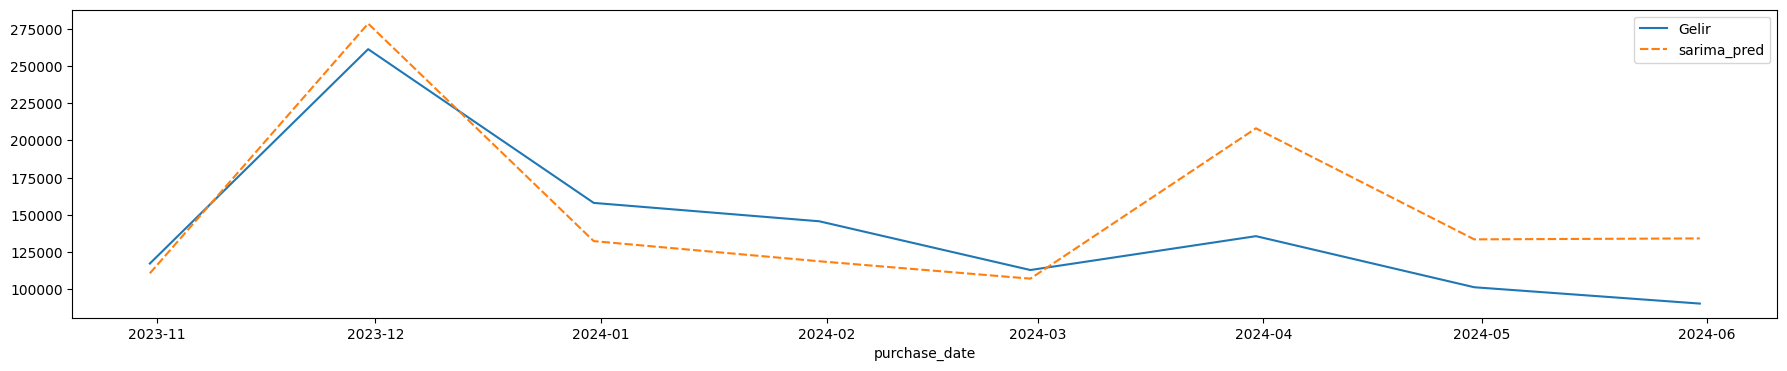

In [129]:
sarima_model = SARIMAX(np.asarray(train), order=(3, 1, 3), seasonal_order=(2,1,2,12))
sarima_model_fit = sarima_model.fit()
sarima_pred = sarima_model_fit.forecast(len(test))

pred_df8["sarima_pred"] = sarima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(pred_df8[['Gelir', 'sarima_pred']])

In [130]:
arima_mape = mean_absolute_percentage_error(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_r = r2_score(pred_df["Gelir"].values, pred_df["arima_pred"].values)
arima_rmse = math.sqrt(mean_squared_error(pred_df["Gelir"].values, pred_df["arima_pred"].values))

sarima_mape8 = mean_absolute_percentage_error(pred_df8["Gelir"].values, pred_df8["sarima_pred"].values)
sarima_r8 = r2_score(pred_df8["Gelir"].values, pred_df8["sarima_pred"].values)
sarima_rmse8 = math.sqrt(mean_squared_error(pred_df8["Gelir"].values, pred_df8["sarima_pred"].values))

results = {
        'ARIMA': [arima_mape,arima_rmse,arima_r],
        'SARIMA8': [sarima_mape8,sarima_rmse8,sarima_r8]}
results = pd.DataFrame(results,index=['MAE','RMSE','R2'])
results

,ARIMA,SARIMA8
MAE,0.250414,0.232382
RMSE,59001.278638,35306.613139
R2,-0.369576,0.509572


<Axes: xlabel='purchase_date'>

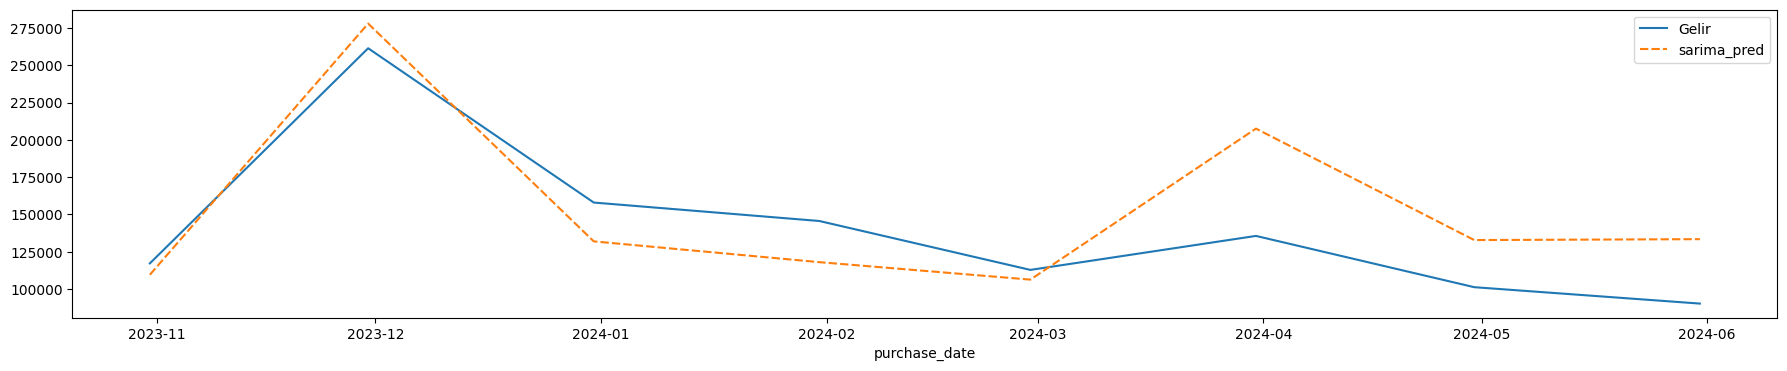

In [52]:
sarima_model = SARIMAX(np.asarray(train), order=(3, 1, 3), seasonal_order=(1,1,1,12))
sarima_model_fit = sarima_model.fit()
sarima_pred = sarima_model_fit.forecast(len(test))

pred_df["sarima_pred"] = sarima_pred.round(2)
plt.figure(figsize=(22,4))
sns.lineplot(pred_df[['Gelir', 'sarima_pred']])

In [54]:
import joblib

In [55]:
joblib.dump(sarima_model_fit, 'sarima_model.pkl')

['sarima_model.pkl']